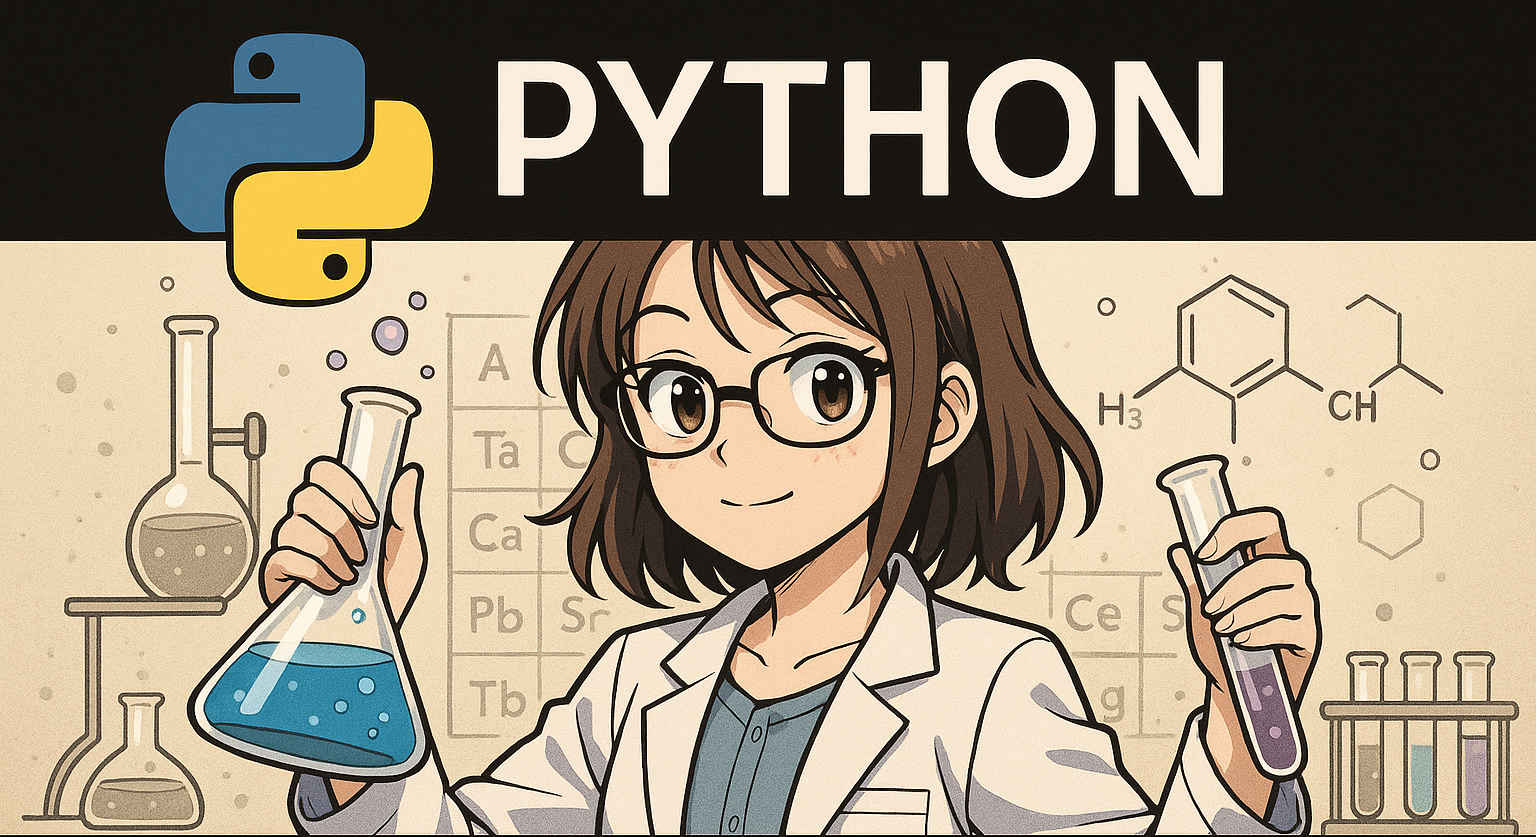
# Simulation en Mécanique des Fluides
# Calcul des pertes de charges
---
## Olivier Carpentier - Applications pour Python généralistes et en Chimie
---






## Supports

Une video tuto est disponible sur Moodle :    
BUT Chimie > But 1 > BC4 (Produire) > Mécanique des Fluides S1   

## Objectifs

Simuler les pertes de charges dans une canalisation à section constante

## Entrées

* Diamètre de la section de la canalisation [mm]
* Longueur de la canalisation [m]
* Rugosité de la paroi [µm]

## Sorties

* Graphiques avec courbe de tendance et coefficients de l'équation
* Tableau de résultats

---

## Protocole d'utilisation

1. Lancer l'éxécution des codes associés aux parties 1,2 et 3
* Installation du module
* Importation des modules
* Lecture et affichage des données initiales

*Le programme va vous demander des autorisations d'accés à votre drive,* **autorisez les accés !!!**

2. **Depuis votre drive** modifier le fichier de données brutes si nécessaire

3. Lancer le code des étapes 4 à 9

4. Si vous modifier à nouveau le fichier des données brutes, relancer le code à partir des étapes 4 jusque 9


1. Installation du module qui permet la lecture des fichiers Google Sheet

In [ ]:
# @title
!pip install --upgrade gspread gspread_dataframe

2. Importation des modules nécessaires au calcul


In [ ]:
# @title
# ---------------------------------------------------------------------
# 1. Chargement des modules nécessaires
#----------------------------------------------------------------------
import pandas as pd                     # Module de lecture de fichier csv
import numpy as np                      # Module de calcul numérique
from scipy.optimize import curve_fit    # Module de calcul scientifique
import matplotlib                       # Import de Matplotlib
import matplotlib.pyplot as plt         # Module de gestion des affichages
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import gspread                          # Gestion des feuilles google sheet
from gspread_dataframe import get_as_dataframe # Gsheet -> Panda dataframe

# Gestion des authentifications
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')
from google.auth import default
creds, _ = default()
from oauth2client.service_account import ServiceAccountCredentials

# Harmonisation typographique
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",           # Pour tous les textes
    "mathtext.fontset": "cm",         # Pour les équations
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Lecture et affichage du fichier des données initiales

In [ ]:
# @title
# Autoriser la lecture d'un fichier Google Sheet
gc = gspread.authorize(creds)

# Chemin et nom du fichier à ouvrir
fichier = "DATA_BRUT_MECAFLU_POMPE"

# Ouvrir la feuille de calcul
feuille = gc.open(fichier).sheet1

# Convertir en DataFrame
df = get_as_dataframe(feuille)
display(df)

# Récupération des colonnes expérimentales
Q =  df["Q"]           # Débit (L/h)
DP = df["DP"]          # Variation de pression (Bar)

,Q,DP
0,5400.0,0.047
1,5000.0,0.041
2,4600.0,0.034
3,4200.0,0.030
4,3800.0,0.025
5,3400.0,0.020
6,3000.0,0.015
7,2600.0,0.013
8,2200.0,0.009
9,1800.0,0.006


4. Entrée des paramètres de l'expérience

In [1]:
# @title
print("2 - Entrée des paramètres utilisateur")
DN  = float(input("Entrer le diamètre de la section étudiée [mm] : "))
L   = float(input("Entrer la longueur de la canalisation [m] :"))
EPS = float(input("Entrer la rugosité de surface [µm] :"))

2 - Entrée des paramètres utilisateur
Entrer le diamètre de la section étudiée [mm] : 25
Entrer la longueur de la canalisation [m] :2
Entrer la rugosité de surface [µm] :0.1


5. Paramètres expériementaux [g, masse volumique du fluide et viscosité dynamique du fluide]

In [2]:
# Paramètres expérimentaux initiaux
g    = 9.81     # Accélération de la pesanteur (m/s2)
r_w  = 1000     # Masse volumique de l'eau (kg/m3)
m_w  = 1e-3     # Viscosité dynamique de l'eau (Pa.s)

6. Calcul des grandeurs physiques

* DH [m.CE] : pertes de charges réelles
* u [m/s] : vitesse du fluide
* Re : nombre de Reynolds
* f Moody : frottement de Moody
* DH Moody [m.CE] : pertes de charge (Moody)
* f Blasius : frottement de Blasius
* DH Blasius [m.CE] : pertes de charge (Blasius)

In [ ]:
# @title
print("3 - Calcul des grandeurs physiques")
# Surfaces
S = np.pi*(DN**2)/4*1e-6     # Surface liée à DN (m)

# Pertes de charges réelles (m.CE)
DHR = DP*1e5/(r_w*g)

# Vitesses (m/s)
U = Q*(1e-3/3600)/S

# Nombre de Reynolds
Re = (r_w * U * DN * 1e-3) / m_w

# Approximation du coefficient de frottement de Moody par l'équation de Swamee
# source (https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae#Colebrook%E2%80%93White_equation)

A1      = (64/Re)**8
A2      = EPS/(3.7*DN)
A3      = 5.74/(Re**0.9)
A4      = (2500/Re)**6
A5      = (np.log(A2+A3)-A4)**(-16)
f_moody = (A1 + 9.5*A5)**(1/8)

# Approximation du coefficient de frottement de Blasius
f_blasius = 0.316 * Re**(-0.25)

# Calcul des charges théoriques de Moody
DH_moody = f_moody * L * (U**2) / (2*DN*1e-3*g)

# Calcul des charges théoriques de Blasius
DH_blasius = f_blasius * L * (U**2) / (2*DN*1e-3*g)

3 - Calcul des grandeurs physiques


7. Affichage du tableau des résultats

In [ ]:
# @title
print("4 - Affichage des données de calcul brut")

df = pd.DataFrame({
    r"QV [L/h]"  : Q,
    r"DP (bar) " : DP,
    r"DH (mCE)"  : DHR,
    r"u (m/s)"   : U,
    r"Re"        : Re,
    r"f Moody"   : f_moody,
    r"DH Moody (mCE)" : DH_moody,
    r"f Blassius": f_blasius,
    r"DH Blassius (mCE)" : DH_blasius,
    r" " : " ",
    r"GP1 " : ["Diamètre","[mm]"] + [DN] + [" ","Section","[mm2]"] + [S*1e6] + [" ","Longueur","[m]"] + [L] + [None]*(len(Q)-11),
    r"GP2 " : ["Rugosité","[µm]"] + [EPS] + [" ","Masse volumique","[kg/m3]"] + [r_w] + [" ","Visco. dyn.","[Pa.s]"] + [m_w] + [None]*(len(Q)-11)
})

display(df)

4 - Affichage des données de calcul brut


,QV [L/h],DP (bar),DH (mCE),u (m/s),Re,f Moody,DH Moody (mCE),f Blassius,DH Blassius (mCE),,GP1,GP2
0,5400.0,0.047,0.479103,3.055775,76394.372684,0.030089,2.291273,0.019007,1.447390,,Diamètre,Rugosité
1,5000.0,0.041,0.417941,2.829421,70735.530263,0.030204,1.971855,0.019377,1.265010,,[mm],[µm]
2,4600.0,0.034,0.346585,2.603068,65076.687842,0.030336,1.676275,0.019785,1.093258,,25.0,0.1
3,4200.0,0.030,0.305810,2.376714,59417.845421,0.030490,1.404541,0.020240,0.932358,,,
4,3800.0,0.025,0.254842,2.150360,53759.003000,0.030674,1.156666,0.020753,0.782560,,Section,Masse volumique
5,3400.0,0.020,0.203874,1.924006,48100.160579,0.030895,0.932663,0.021338,0.644146,,[mm2],[kg/m3]
6,3000.0,0.015,0.152905,1.697653,42441.318158,0.031169,0.732548,0.022016,0.517438,,490.873852,1000
7,2600.0,0.013,0.132518,1.471299,36782.475737,0.031515,0.556345,0.022818,0.402810,,,
8,2200.0,0.009,0.091743,1.244945,31123.633316,0.031971,0.404084,0.023791,0.300702,,Longueur,Visco. dyn.
9,1800.0,0.006,0.061162,1.018592,25464.790895,0.032598,0.275808,0.025015,0.211652,,[m],[Pa.s]


8. Calcul de la fonction d'interpolation

La fonction est de la forme

$y = a \cdot x^b $


In [ ]:
# @title
print("5 - Interpolation par une fonction puissance")
print(" ")
# Modèle de la fonction de puissance
def power_func(x,a,b):
    return a*x**b

# Calcul des paramètres d'interpolation
params, _ = curve_fit(power_func,U,DHR)
a, b = params

# Courbe avec les paramètres calculés
DHR_interp = power_func(U,a,b)

# Calcul du coefficient R2
residuals = DHR - DHR_interp
ss_res = np.sum(residuals**2)
ss_tot = np.sum((DHR - np.mean(DHR))**2)
R2     = 1 - (ss_res/ss_tot)

# Courbe lissée
x_fit = np.linspace(min(U),max(U),100)
y_fit = power_func(x_fit,a,b)

# Légende
a_fmt  = f"{a:.4g}"
b_fmt  = f"{b:.4g}"
r2_fmt = f"{R2:.4g}"
eq_fmt = rf"$y = {a_fmt} \cdot x^{{{b_fmt}}}$" + f"\n$R^2 = {r2_fmt}$"
print("La fonction puissance de type y = a x^b à pour ceofficient : ")
print(" ")
print(f" Coefficient a : {a_fmt}")
print(f" Coefficient b : {b_fmt}")
print(f" Coefficient R2 : {r2_fmt}")
print(" ")

5 - Interpolation par une fonction puissance
 
La fonction puissance de type y = a x^b à pour ceofficient : 
 
 Coefficient a : 0.06122
 Coefficient b : 1.84
 Coefficient R2 : 0.9987
 


9. Afficher le graphique avec la courbe de tendance

6 - Partie graphique


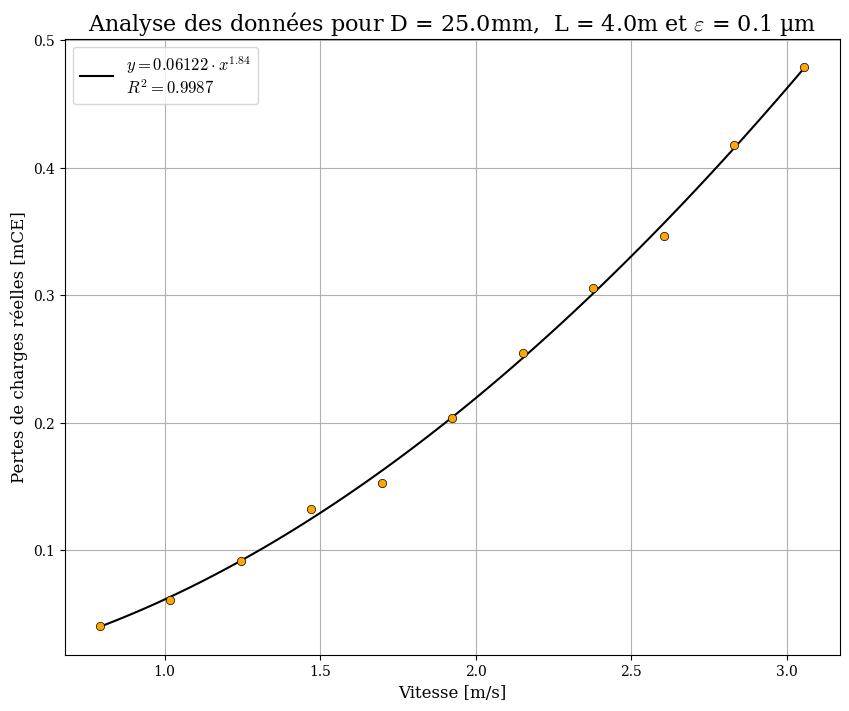

In [ ]:
# @title
print("6 - Partie graphique")

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(1,1)
# ---- Partie graphique ----
ax1 = fig.add_subplot(gs[0])
ax1.plot(x_fit,y_fit,"black")
ax1.plot(U,DHR,
         marker="o",
         markersize=6,
         markerfacecolor="orange",
         markeredgecolor="black",
         markeredgewidth=0.5,
         linestyle="None"
         )
ax1.set_xlabel("Vitesse [m/s]", fontsize=12)
ax1.set_ylabel("Pertes de charges réelles [mCE]", fontsize=12)
ax1.set_title(rf"Analyse des données pour D = {DN}mm,  L = {L}m et $\varepsilon$ = {EPS} µm", fontsize=16)
ax1.tick_params(axis="both", which="major", labelsize=10)
ax1.legend([eq_fmt], loc="upper left",fontsize="12", frameon=True)
ax1.grid(True)

plt.show()